In [1]:
import icecube
from icecube.icetray.i3logging import log_info, log_fatal
from icecube import dataclasses, dataio, icetray, simclasses, MuonGun, hdfwriter
import matplotlib.pyplot as plt
import numpy as np
from I3Tray import I3Tray
import glob
from scipy.interpolate import interp1d
from asym_uncertainties import add_asym

**Utility functions:**

In [2]:
#Function to read the GCD file and make the extruded polygon which
#defines the edge of the in-ice array
def MakeSurface(gcdName, padding):
    file = dataio.I3File(gcdName, "r")
    frame = file.pop_frame()
    while not "I3Geometry" in frame:
        frame = file.pop_frame()
    geometry = frame["I3Geometry"]
    xyList = []
    zmax = -1e100
    zmin = 1e100
    step = int(len(geometry.omgeo.keys())/10)
    print("Loading the DOM locations from the GCD file")
    for i, key in enumerate(geometry.omgeo.keys()):
        if i % step == 0:
            print( "{0}/{1} = {2}%".format(i,len(geometry.omgeo.keys()), int(round(i/len(geometry.omgeo.keys())*100))))
            
        if key.om in [61, 62, 63, 64] and key.string <= 81: #Remove IT...
            continue

        pos = geometry.omgeo[key].position

        if pos.z > 1500:
            continue
            
        xyList.append(pos)
        i+=1
    
    return MuonGun.ExtrudedPolygon(xyList, padding) 

def get_position_along_track(particle, length):
    return particle.pos + dataclasses.I3Position(length, particle.dir.theta, particle.dir.phi, dataclasses.I3Position.sph)

**Interpolation of neutrino interaction probabilities from** https://arxiv.org/pdf/1106.3723.pdf

In [3]:
# energies (in GeV) corresponding to the following cross sections (in cm^2)
E = [50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000, 500000, 1e6, 2e6, 5e6, 1e7, 2e7, 5e7, 1e8, 2e8, 5e8, 1e9, 2e9, 5e9, 1e10, 2e10, 5e10, 1e11, 2e11, 5e11]

# neutrino
sigma_nu_CC = [i * 1e-36 for i in 
               [0.32, 0.65, 1.3, 3.2, 6.2, 12, 27, 47, 77, 140, 210, 310, 490, 690, 950, 1400, 1900, 2600, 3700, 4800, 6200, 8700, 11000, 14000, 19000, 24000, 30000, 39000, 48000, 59000, 75000]]
sigma_nu_NC = [i * 1e-36 for i in 
               [0.10, 0.20, 0.41, 1.0, 2.0, 3.8, 8.6, 15, 26, 49, 75, 110, 180, 260, 360, 540, 730, 980, 1400, 1900, 2400, 3400, 4400, 5600, 7600, 9600, 12000, 16000, 20000, 24000, 31000]]

# antineutrino
sigma_nu_bar_CC = [i * 1e-36 for i in 
                   [0.15, 0.33, 0.69, 1.8, 3.6, 7, 17, 31, 55, 110, 180, 270, 460, 660, 920, 1400, 1900, 2500, 3700, 4800, 6200, 8700, 11000, 14000, 19000, 24000, 30000, 39000, 48000, 59000, 75000]]
sigma_nu_bar_NC = [i * 1e-36 for i in 
                   [0.05, 0.12, 0.24, 0.61, 1.20, 2.4, 5.8, 11, 19, 39, 64, 99, 170, 240, 350, 530, 730, 980, 1400, 1900, 2400, 3400, 4400, 5600, 7600, 9600, 12000, 16000, 20000, 24000, 31000]]

# callable functions
func_sigma_nu_CC = interp1d(E, sigma_nu_CC)
func_sigma_nu_NC = interp1d(E, sigma_nu_NC)
func_sigma_nu_bar_CC = interp1d(E, sigma_nu_bar_CC)
func_sigma_nu_bar_NC = interp1d(E, sigma_nu_bar_NC)

In [4]:
# upper and lower errors in cm^2

# neutrino
nu_CC_down = [i * 0.01 * 1e-36 for i in
            [2.3, 2.0, 1.8, 1.7, 1.6, 1.6, 1.5, 1.4, 1.3, 1.2, 1.2, 1.1, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0, 1.1, 1.2, 1.2, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]]  # in %
nu_CC_up = [i * 0.01 * 1e-36 for i in
            [4.1, 3.8, 3.5, 3.2, 3.0, 2.7, 2.3, 2.0, 1.8, 1.5, 1.4, 1.5, 1.6, 1.7, 1.9, 2.0, 2.2, 2.3, 2.5, 2.7, 2.8, 3.0, 3.1, 3.3, 3.4, 3.6, 3.7, 3.8, 4.0, 4.1, 4.2]]

nu_NC_down = [i * 0.01 * 1e-36 for i in
            [1.9, 1.8, 1.6, 1.5, 1.4, 1.3, 1.3, 1.2, 1.1, 1.0, 1.0, 0.9, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.9, 0.9, 1.0, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.7, 1.8, 1.9, 2.0]]
nu_NC_up = [i * 0.01 * 1e-36 for i in
            [3.8, 3.5, 3.2, 2.9, 2.7, 2.4, 2.1, 1.8, 1.6, 1.3, 1.2, 1.2, 1.3, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.7, 2.9, 3.0, 3.2, 3.4, 3.5, 3.6, 3.8, 3.9, 4.0, 4.2]]

# antineutrino
nu_bar_CC_down = [i * 0.01 * 1e-36 for i in
                [9.0, 7.4, 6.5, 5.7, 5.2, 4.6, 3.7, 3.0, 2.3, 1.7, 1.4, 1.2, 1.1, 1.0, 1.0, 0.9, 0.9, 0.9, 0.9, 1.0, 1.0, 1.1, 1.2, 1.2, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]]
nu_bar_CC_up = [i * 0.01 * 1e-36 for i in
                [15.0, 13.3, 11.9, 10.5, 9.4, 8.3, 6.5, 5.1, 3.8, 2.5, 1.9, 1.7, 1.7, 1.8, 1.9, 2.1, 2.2, 2.3, 2.5, 2.7, 2.8, 3.0, 3.1, 3.3, 3.4, 3.6, 3.7, 3.8, 4.0, 4.1, 4.2]]

nu_bar_NC_down = [i * 0.01 * 1e-36 for i in
                [6.4, 5.7, 5.1, 4.6, 4.2, 3.8, 3.2, 2.7, 2.1, 1.5, 1.2, 1.0, 0.9, 0.8, 0.8, 0.8, 0.8, 0.8, 0.9, 0.9, 1.0, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.7, 1.8, 1.9, 2.0]]
nu_bar_NC_up = [i * 0.01 * 1e-36 for i in
                [12.0, 10.7, 9.6, 8.6, 7.8, 7.0, 5.7, 4.6, 3.6, 2.4, 1.7, 1.4, 1.4, 1.5, 1.6, 1.9, 2.0, 2.2, 2.4, 2.6, 2.7, 2.9, 3.0, 3.2, 3.4, 3.5, 3.6, 3.8, 3.9, 4.0, 4.2]]

# callable functions upper and lower bounds
# neutrino cross sections
func_sigma_nu_CC_max = interp1d(E, nu_CC_up)
func_sigma_nu_NC_max = interp1d(E, nu_NC_up)

func_sigma_nu_CC_min = interp1d(E, nu_CC_down)
func_sigma_nu_NC_min = interp1d(E, nu_NC_down)

# antineutrino cross sections
func_sigma_nu_bar_CC_max = interp1d(E, nu_bar_CC_up)
func_sigma_nu_bar_NC_max = interp1d(E, nu_bar_NC_up)

func_sigma_nu_bar_CC_min = interp1d(E, nu_bar_CC_down)
func_sigma_nu_bar_NC_min = interp1d(E, nu_bar_NC_down)

In [5]:
# total cross sections and errors

# neutrino
x0 = list(zip(sigma_nu_CC, sigma_nu_NC))
s1 = list(zip(nu_CC_down, nu_NC_down))
s2 = list(zip(nu_CC_up, nu_NC_up))

sigma_tot_nu = []
sigma_tot_nu_down = []
sigma_tot_nu_up = []
for i in range(len(list(zip(sigma_nu_CC, sigma_nu_NC)))):
    tot, s_up, s_down = add_asym(x0[i], s1[i], s2[i], order=2)
    sigma_tot_nu.append(tot)
    sigma_tot_nu_down.append(s_up)
    sigma_tot_nu_up.append(s_down)

# antineutrino
x0 = list(zip(sigma_nu_bar_CC, sigma_nu_bar_NC))
s1 = list(zip(nu_bar_CC_down, nu_bar_NC_down))
s2 = list(zip(nu_bar_CC_up, nu_bar_NC_up))

sigma_tot_nu_bar = []
sigma_tot_nu_bar_down = []
sigma_tot_nu_bar_up = []
for i in range(len(list(zip(sigma_nu_bar_CC, sigma_nu_bar_NC)))):
    tot, s_up, s_down = add_asym(x0[i], s1[i], s2[i], order=2)
    sigma_tot_nu_bar.append(tot)
    sigma_tot_nu_bar_down.append(s_up)
    sigma_tot_nu_bar_up.append(s_down)
    

# callable functions    
func_sigma_tot_nu = interp1d(E, sigma_tot_nu)
func_sigma_tot_nu_max = interp1d(E, sigma_tot_nu_up)
func_sigma_tot_nu_min = interp1d(E, sigma_tot_nu_down)

func_sigma_tot_nu_bar = interp1d(E, sigma_tot_nu_bar)
func_sigma_tot_nu_bar_max = interp1d(E, sigma_tot_nu_bar_up)
func_sigma_tot_nu_bar_min = interp1d(E, sigma_tot_nu_bar_down)

**Class that selects background candidates**

In [6]:
# Module to select background candidate events
class BackgroundCandidateSelector(icetray.I3Module):
    """
        This module selects events that can mimic Long Lived Particle (LLP) signature.
        A stopping muon followed by a collinear neutrino interacting some distance after
        the stop point can give a similar track gap signature as LLPs. This module selects
        events with one or many stopping muons, that aren't too close to the detector boundary,
        and that are accompanied by a collinear neutrino(s).
    """
    def __init__(self,ctx):
        icetray.I3Module.__init__(self,ctx)

        self.gcdFile = ""
        self.AddParameter("GCDFile", "GCD file which defines the in-ice volume", self.gcdFile)

        self.padding = 60. * icetray.I3Units.m # default no padding
        self.AddParameter("Padding", "", self.padding)

    def Configure(self): 
        # counters for lateral distance check
        self.rejected_neutrino_counter = 0
        self.tot_number_of_neutrinos = 0
        self.approved_event_counter = 0
        self.tot_number_of_events = 0
        
        # track gap properties
        self.minimum_stop_length = 50. # minimum muon length inside detector
        self.minimum_exit_length = 50. # minimum distance from neutrino interaction to detector edge
        self.minimum_track_gap = 30. # shortest visible track gap
        self.max_cone_angle = 20*np.pi/180 # 20 deg separation between nu and mu track at a certain point
        
        # padding for gcd file, use 0 by default
        self.padding = self.GetParameter("Padding")

        # create surface for detector volume
        self.gcdFile = self.GetParameter("GCDFile")
        if self.gcdFile != "":
            self.surface = MakeSurface(self.gcdFile, self.padding)
        else:
            self.surface = MuonGun.Cylinder(1000,500) # approximate detector volume
        
    def DAQ(self, frame):
        # stopping muon/bundle should not be too close to boundary
        self.longest_distance_from_boundary = 0 # longest distance from entering volume
        self.shortest_distance_to_boundary = 999999 # shortest distance to exiting volume
        self.longest_stopping_muon = None # will hold the muon that traveled furthest in the volume
        
        if not self.CheckForNeutrino(frame):
            return False
        if not self.SelectStoppingMuon(frame):
            return False
        # write probability to file
        self.tot_number_of_events += 1
        self.CalculateTrackGapProbability(frame)
        bkginfo = frame["LLPBackgroundProbability"]
        if not bkginfo["TotalNeutrinoInteractionProbability_asym"] == 0:
            # good background candidate
            self.approved_event_counter += 1
            self.PushFrame(frame)
        return True
    
    def NeutrinoInteractionProbability(self, l1, l2, energy, species):
        """ probability for neutrino to interact between distance l1 and l2 """
        rhoH20 = 0.92 # g/cm3 for -30C ice
        NA = 6.02214076E23 # mol
        n = rhoH20 * NA # nucleon density (implicit 1 g/mol for nucleons)

        if species == 12 or species == 14 or species == 16:
            sigma_CC = func_sigma_nu_CC(energy) # neutrino nucleon cross section
            sigma_NC = func_sigma_nu_NC(energy)
            sigma_tot = func_sigma_tot_nu(energy)
            
            # interpolated sigma errors for error propagation
            sigma_CC_max = func_sigma_nu_CC_max(energy)
            sigma_CC_min = func_sigma_nu_CC_min(energy)
            sigma_NC_max = func_sigma_nu_NC_max(energy)
            sigma_NC_min = func_sigma_nu_NC_min(energy)
            sigma_tot_max = func_sigma_tot_nu_max(energy)
            sigma_tot_min = func_sigma_tot_nu_min(energy)

        if species == -12 or species == -14 or species == -16:
            sigma_CC = func_sigma_nu_bar_CC(energy)
            sigma_NC = func_sigma_nu_bar_NC(energy)
            sigma_tot = func_sigma_tot_nu_bar(energy)

            # interpolated sigma errors for error propagation
            sigma_CC_max = func_sigma_nu_bar_CC_max(energy)
            sigma_CC_min = func_sigma_nu_bar_CC_min(energy)
            sigma_NC_max = func_sigma_nu_bar_NC_max(energy)
            sigma_NC_min = func_sigma_nu_bar_NC_min(energy)
            sigma_tot_max = func_sigma_tot_nu_bar_max(energy)
            sigma_tot_min = func_sigma_tot_nu_bar_min(energy)

        # length in cm
        interaction_prob = np.exp(-(l1*100)*n*sigma_tot) - np.exp(-(l2*100)*n*sigma_tot) # portion of interaction pdf between l1 and l2
        CC_interaction_prob = np.exp(-(l1*100)*n*sigma_CC) - np.exp(-(l2*100)*n*sigma_CC)
        NC_interaction_prob = np.exp(-(l1*100)*n*sigma_NC) - np.exp(-(l2*100)*n*sigma_NC)
        
        # upper and lower P errors by error propagation    
        dPdsigma_CC = n * (l2 * np.exp(-l2*n*sigma_CC) - l1 * np.exp(-l1*n*sigma_CC))
        P_CC_sigma_max = dPdsigma_CC * sigma_CC_max
        P_CC_sigma_min = dPdsigma_CC * sigma_CC_min
        
        dPdsigma_NC = n * (l2 * np.exp(-l2*n*sigma_NC) - l1 * np.exp(-l1*n*sigma_NC))
        P_NC_sigma_max = dPdsigma_NC * sigma_NC_max
        P_NC_sigma_min = dPdsigma_NC * sigma_NC_min
        
        dPdsigma_tot = n * (l2 * np.exp(-l2*n*sigma_tot) - l1 * np.exp(-l1*n*sigma_tot))
        P_tot_sigma_max = dPdsigma_tot * sigma_tot_max
        P_tot_sigma_min = dPdsigma_tot * sigma_tot_min
        
        # returns [x0, sigma_min, sigma_max] for (CC+NC), CC, NC
        return [interaction_prob, P_tot_sigma_min, P_tot_sigma_max], [CC_interaction_prob, P_CC_sigma_min, P_CC_sigma_max], [NC_interaction_prob, P_NC_sigma_min, P_NC_sigma_max]
    
    def CalculateTrackGapProbability(self, frame):
        # print("-------------")
        # lengths for probability of neutrino interaction
        l1 = self.longest_stopping_muon.length + self.minimum_track_gap
        l2 = self.longest_stopping_muon.length + self.shortest_distance_to_boundary - self.minimum_exit_length
        total_interaction_prob = 0
        total_cascade_prob = 0
        total_tracklike_prob = 0
        total_NC_interaction_prob = 0
        
        # asym variables
        total_interaction_prob_asym = 0
        total_interaction_prob_min_asym = 0
        total_interaction_prob_max_asym = 0
        
        total_cascade_prob_asym = 0
        total_cascade_prob_min_asym = 0
        total_cascade_prob_max_asym = 0
        
        total_tracklike_prob_asym = 0
        total_tracklike_prob_min_asym = 0
        total_tracklike_prob_max_asym = 0
        
        total_NC_interaction_prob_asym = 0
        total_NC_interaction_prob_min_asym = 0
        total_NC_interaction_prob_max_asym = 0
        
        for p in frame["I3MCTree_preMuonProp"]:
            if p.is_neutrino:
                self.tot_number_of_neutrinos += 1
                if self.CheckLateralDistance(l2, p): # self.CheckLateralDistance(l1, p)
                    interaction_prob, NC_interaction_prob, CC_interaction_prob = self.NeutrinoInteractionProbability(l1, l2, p.energy, p.type)
                    
                    x0 = [total_interaction_prob_asym, interaction_prob[0]]
                    s1 = [total_interaction_prob_min_asym, interaction_prob[1]]
                    s2 = [total_interaction_prob_max_asym, interaction_prob[2]]
                    total_interaction_prob_asym, total_interaction_prob_min_asym, total_interaction_prob_max_asym = add_asym(x0, s1, s2, order=2)            
                    
                    x0 = [total_NC_interaction_prob_asym, NC_interaction_prob[0]]
                    s1 = [total_NC_interaction_prob_min_asym, NC_interaction_prob[1]]
                    s2 = [total_NC_interaction_prob_max_asym, NC_interaction_prob[2]]
                    total_NC_interaction_prob_asym, total_NC_interaction_prob_min_asym, total_NC_interaction_prob_max_asym = add_asym(x0, s1, s2, order=2)   
                    
                    if p.type == 12 or p.type == -12: 
                        x0 = [total_cascade_prob_asym, CC_interaction_prob[0]]
                        s1 = [total_cascade_prob_min_asym, CC_interaction_prob[1]]
                        s2 = [total_cascade_prob_max_asym, CC_interaction_prob[2]]
                        total_cascade_prob_asym, total_cascade_prob_min_asym, total_cascade_prob_max_asym = add_asym(x0, s1, s2, order=2)   
                    
                    if p.type == 14 or p.type == -14 or p.type == 16 or p.type == -16: 
                        x0 = [total_tracklike_prob_asym, CC_interaction_prob[0]]
                        s1 = [total_tracklike_prob_min_asym, CC_interaction_prob[1]]
                        s2 = [total_tracklike_prob_max_asym, CC_interaction_prob[2]]
                        total_tracklike_prob_asym, total_tracklike_prob_min_asym, total_tracklike_prob_max_asym = add_asym(x0, s1, s2, order=2)
                        
                else:
                    self.rejected_neutrino_counter += 1
                    #print(self.longest_stopping_muon.id.minorID)
        
        # save information to frame
        interaction_map = dataclasses.I3MapStringDouble()
        interaction_map["MinLength"] = l1
        interaction_map["MaxLength"] = l2
        interaction_map["AvailableInteractionLength"] = l2 - l1
        interaction_map["StoppingMuonMinorID"] = float(self.longest_stopping_muon.id.minorID)
        frame["LLPBackgroundProbability"] = interaction_map

        # interaction probabilities
        interaction_map["TotalNeutrinoInteractionProbability_asym"] = total_interaction_prob_asym
        interaction_map["TotalNeutrinoInteractionProbability_down"] = total_interaction_prob_min_asym
        interaction_map["TotalNeutrinoInteractionProbability_up"] = total_interaction_prob_max_asym

        interaction_map["CCCascadeLikeProbability_asym"] = total_cascade_prob_asym
        interaction_map["CCCascadeLikeProbability_down"] = total_cascade_prob_min_asym
        interaction_map["CCCascadeLikeProbability_up"] = total_cascade_prob_max_asym

        interaction_map["CCTrackLikeProbability_asym"] = total_tracklike_prob_asym
        interaction_map["CCTrackLikeProbability_down"] = total_tracklike_prob_min_asym
        interaction_map["CCTrackLikeProbability_up"] = total_tracklike_prob_max_asym

        interaction_map["NCInteractionProbability_asym"] = total_NC_interaction_prob_asym
        interaction_map["NCInteractionProbability_down"] = total_NC_interaction_prob_min_asym
        interaction_map["NCInteractionProbability_up"] = total_NC_interaction_prob_max_asym
        
    def CheckForNeutrino(self, frame):
        mctree = frame['SignalI3MCTree']
        primary = mctree.get_head()
        children = mctree.children(primary)
        has_neutrino = False
        for c in children:
            if c.is_neutrino:
                has_neutrino = True
                break
        return has_neutrino
    
    def SelectStoppingMuon(self, frame):
        through_going = False
        n_stop = 0
        for track in MuonGun.Track.harvest(frame['SignalI3MCTree'], frame['MMCTrackList']):
            intersections = self.surface.intersection(track.pos, track.dir)
            #print(get_position_along_track(track, intersections.first), get_position_along_track(track, intersections.second))
            if intersections.first >= track.length: # Stop before volume
                continue
            elif intersections.second >= track.length: # Stop inside volume
                n_stop += 1
                # update longest stopping muon lengths if applicable
                from_boundary = (track.length - intersections.first)
                to_boundary = (intersections.second - track.length)
                if from_boundary > self.longest_distance_from_boundary:
                    self.longest_distance_from_boundary = from_boundary
                if to_boundary < self.shortest_distance_to_boundary:
                    self.shortest_distance_to_boundary = to_boundary
                    self.longest_stopping_muon = track

            elif track.length > intersections.second: # Stop after volume
                through_going = True # one of these ruins the whole event
                break 
            else: # Not entering volume
                continue

        # avoid stopping muon/bundles to close to boundaries
        distance_check = self.shortest_distance_to_boundary > (self.minimum_exit_length + self.minimum_track_gap) and self.longest_distance_from_boundary > self.minimum_stop_length
        # candidates have no through going muons and a stopping muon not too close to boundary
        good_event = n_stop >= 1 and (not through_going) and distance_check
        return good_event # true or false
    
    def CheckLateralDistance(self, length, neutrino):
        """
        Checks if the neutrino track passes through a circle of radius r on a surface. The plane is set at length l1 or l2 along the muon track.
        r is determined by the fixed angle alpha from the muon stopping point and d, the distance from the muon stopping point to the plane.
        length: l1 or l2
        muon, neutrino: I3Particles
        """
        # geometry
        d = length - self.longest_stopping_muon.length # distance from muon stopping point to surface
        r = np.tan(self.max_cone_angle) * d # radius of circle on surface

        # compute intersection points
        pointonplane = self.longest_stopping_muon.pos + dataclasses.I3Position(length, self.longest_stopping_muon.dir.theta, self.longest_stopping_muon.dir.phi, dataclasses.I3Position.sph) # intersection point of muon track with plane

        normal = dataclasses.I3Position(1, self.longest_stopping_muon.dir.theta, self.longest_stopping_muon.dir.phi, dataclasses.I3Position.sph) # normed vector orthogonal to plane
        nu_dir = dataclasses.I3Position(1, neutrino.dir.theta, neutrino.dir.phi, dataclasses.I3Position.sph) # normed directional vector of neutrino track
        intersection_lam = np.sum(normal * (pointonplane - neutrino.pos))/np.sum(normal * nu_dir) # length until intersection along neutrino track
        intersection_point = neutrino.pos + dataclasses.I3Position(intersection_lam, neutrino.dir.theta, neutrino.dir.phi, dataclasses.I3Position.sph)

        distance = np.linalg.norm(pointonplane - intersection_point) # distance between both intersection points
        # print(distance, r, length)
        return (distance <= r)
    
    def Finish(self):
        print(f"Rejected neutrinos {self.rejected_neutrino_counter}/{self.tot_number_of_neutrinos}")
        print(f"Rejected events {self.tot_number_of_events-self.approved_event_counter}/{self.tot_number_of_events}")

In [7]:
filelist = list(glob.glob("/data/sim/IceCube/2020/generated/CORSIKA-in-ice/20904/0198000-0198999/detector/IC86.2020_corsika.020904.198*.i3.zst"),)
n_files = 1
filelist = filelist[0:n_files] # how many files to use?
print("Number of files ", len(filelist))
#print("Total number of events ", len(filelist)*10000)
gcdfile = "gcdfile.i3.gz"
output_name = "Selected_bkg_candidates_"+str(n_files)+"files.i3.gz"

tray = I3Tray()

tray.Add("I3Reader", filenamelist=filelist)
tray.Add(BackgroundCandidateSelector, GCDFile = gcdfile)
tray.Add("I3Writer", filename=output_name)

tray.Execute()

Number of files  1
Loading the DOM locations from the GCD file
0/5484 = 0%
548/5484 = 10%
1096/5484 = 20%
1644/5484 = 30%
2192/5484 = 40%
2740/5484 = 50%
3288/5484 = 60%
3836/5484 = 70%
4384/5484 = 80%
4932/5484 = 90%
5480/5484 = 100%
Rejected neutrinos 936/6752
Rejected events 73/1996


NOTICE (I3Tray): I3Tray finishing... (I3Tray.cxx:526 in void I3Tray::Execute(bool, unsigned int))


In [8]:

tray = I3Tray()
tray.Add("I3Reader", FileNameList=[output_name])
tray.Add(
    hdfwriter.I3SimHDFWriter,
    keys=["PolyplopiaPrimary", "CorsikaWeightMap", "LLPBackgroundProbability"],
    output="Selected_bkg_candidates_"+str(n_files)+"files.hdf5",
)

tray.Execute()

NOTICE (I3Tray): I3Tray finishing... (I3Tray.cxx:526 in void I3Tray::Execute(bool, unsigned int))


Loading the DOM locations from the GCD file
0/5484 = 0%
548/5484 = 10%
1096/5484 = 20%
1644/5484 = 30%
2192/5484 = 40%
2740/5484 = 50%
3288/5484 = 60%
3836/5484 = 70%
4384/5484 = 80%
4932/5484 = 90%
5480/5484 = 100%


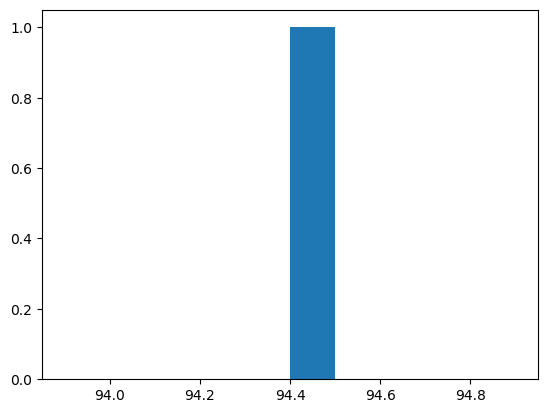